<a href="https://colab.research.google.com/github/dungdt-infopstats/TV-command-synthesis/blob/main/notebooks/DDSS_Test_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

tridungdo_ddss_aug_ratio_test_path = kagglehub.dataset_download('tridungdo/ddss-aug-ratio-test')
tridungdo_model_split_pytorch_default_1_path = kagglehub.model_download('tridungdo/model-split/PyTorch/default/1')

print('Data source import complete.')


# Get Data

In [ ]:
!gdown 1Y0qQlfvzfiDCVCTVFu9pmUHWnAlgV8_V

Downloading...
From (original): https://drive.google.com/uc?id=1Y0qQlfvzfiDCVCTVFu9pmUHWnAlgV8_V
From (redirected): https://drive.google.com/uc?id=1Y0qQlfvzfiDCVCTVFu9pmUHWnAlgV8_V&confirm=t&uuid=f4bcec05-7c3c-497e-b732-5200757046ba
To: /kaggle/working/test-extend.zip
100%|███████████████████████████████████████| 2.16G/2.16G [00:21<00:00, 101MB/s]


In [ ]:
!unzip -q test-extend.zip -d data

In [ ]:
input_path = "/kaggle/input/ddss-aug-ratio-test"

In [ ]:
import os
import json
import pandas as pd
root_path = os.path.join(input_path, 'test')
list_json = []
for folder in os.listdir(root_path):
    for file in os.listdir(os.path.join(root_path, folder)):
        if file.endswith('.json'):
            with open(os.path.join(root_path, folder, file), 'r') as f:
                data = json.load(f)
                data['id'] = file.split('.')[0]
                list_json.append(data)

df_info = pd.DataFrame(list_json)

In [ ]:
df_info.head()

,clean_path,noise_path,mode,snr_db,labels,id
0,/content/concat_speech/sample/single_active_bd...,/content/musan/speech/librivox/speech-librivox...,overlap,13.815666,"[{'label': 'active', 'start': 0.0, 'end': 1.348}]",single_active_bd116cf7_aug0-3
1,/content/concat_speech/sample/single_active_bd...,/content/musan/speech/librivox/speech-librivox...,prepend,0.609248,"[{'label': 'active', 'start': 1.78544425099277...",single_active_bd116cf7_aug0-1
2,/content/concat_speech/sample/single_active_bd...,/content/musan/speech/us-gov/speech-us-gov-004...,prepend,15.549012,"[{'label': 'active', 'start': 1.0, 'end': 2.34...",single_active_bd116cf7_aug3-4
3,/content/concat_speech/sample/single_active_bd...,/content/musan/speech/librivox/speech-librivox...,append,-2.075359,"[{'label': 'active', 'start': 0.0, 'end': 1.34...",single_active_bd116cf7_aug0-0
4,/content/concat_speech/sample/single_active_bd...,/content/musan/speech/us-gov/speech-us-gov-000...,append,12.808796,"[{'label': 'active', 'start': 0.0, 'end': 1.34...",single_active_bd116cf7_aug1-3


# Model

In [ ]:
import torch
import torch.nn as nn
import torchaudio


class DDSSModel(nn.Module):
    def __init__(self, hidden_dim=256, num_layers=2, bidirectional=True, dropout=0.3):
        super(DDSSModel, self).__init__()

        # Base model: Wav2Vec2 (ASR Base)
        bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
        self.feature_extractor = bundle.get_model()

        # Freeze Wav2Vec2
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        # LSTM
        self.lstm = nn.LSTM(
            input_size=bundle._params['encoder_embed_dim'],
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional
        )

        lstm_output_dim = hidden_dim * (2 if bidirectional else 1)

        # Frame-level classifier (MLP thay vì 1 tầng)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, lstm_output_dim // 2),
            nn.BatchNorm1d(lstm_output_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(lstm_output_dim // 2, lstm_output_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(lstm_output_dim // 4, 1)  # binary logit
        )

    def forward(self, waveforms):
        """
        waveforms: Tensor [B, T_audio] (mono audio, 16kHz)
        """
        with torch.no_grad():
            features, _ = self.feature_extractor.extract_features(waveforms)
            x = features[-1]  # [B, T_feat, F]

        # LSTM
        x, _ = self.lstm(x)  # [B, T_feat, H]

        # Classifier cho từng frame
        B, T, H = x.shape
        x = x.reshape(-1, H)          # [B*T, H]
        out = self.classifier(x)      # [B*T, 1]
        out = out.view(B, T)          # [B, T]
        return out

In [ ]:
model = DDSSModel()
model.load_state_dict(torch.load("/kaggle/input/model-split/pytorch/default/1/DDSS_model.pt"))

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:01<00:00, 330MB/s] 


<All keys matched successfully>

# Dataset

In [ ]:
import os
import json
import pandas as pd

def collect_json_to_df(root_dir: str, flatten: bool = True) -> pd.DataFrame:
    """
    Gom tất cả file JSON trong root_dir thành DataFrame.

    Args:
        root_dir (str): thư mục gốc chứa các thư mục con.
        flatten (bool): nếu True, mỗi label trong json sẽ thành 1 dòng riêng.
                        nếu False, labels sẽ giữ nguyên dạng list trong 1 cột.

    Returns:
        pd.DataFrame
    """
    records = []

    for dirpath, _, filenames in os.walk(root_dir):
        for file in filenames:
            if file.endswith(".json"):
                json_path = os.path.join(dirpath, file)
                folder_name = os.path.basename(dirpath)

                # audio nằm cùng chỗ, tên trùng với folder
                audio_path = os.path.join(dirpath, file.replace('.json','.wav'))

                with open(json_path, "r", encoding="utf-8") as f:
                    data = json.load(f)

                if flatten:
                    for entry in data['labels']:
                        records.append({
                            "id": folder_name,
                            "id_detail": file.split('.')[0],
                            "audio_path": audio_path,
                            "label": entry.get("label"),
                            "start": entry.get("start"),
                            "end": entry.get("end")
                        })
                else:
                    records.append({
                        "id": folder_name,
                        "audio_path": audio_path,
                        "labels": data
                    })

    return pd.DataFrame(records)

In [ ]:
import torch
from torch.utils.data import Dataset
import torchaudio

def frame_wav(wav, frame_size, hop_size):
    wav = wav.squeeze(0)  # (N,)
    frames = wav.unfold(0, frame_size, hop_size)  # shape (num_frames, frame_size)
    return frames

def label_frames(num_frames, frame_size, hop_size, sr, annotations):
    labels = torch.zeros(num_frames, dtype=torch.long)  # mặc định = 0

    for _, row in annotations.iterrows():
        start_sample = int(row['start'] * sr)
        end_sample = int(row['end'] * sr)

        # quy đổi sample về index frame
        start_frame = max(0, (start_sample - frame_size) // hop_size + 1)
        end_frame   = min(num_frames, end_sample // hop_size)

        if row['label'] == 'active':
            labels[start_frame:end_frame+1] = 1

    return labels

class DDSSDataset(Dataset):
    def __init__(self, annotations_file, frame_size=400, hop_size=160, target_sr=16000, transform=None, key = None):
        self.annotations_file = annotations_file
        self.key = key
        if self.key is not None:
            self.list_id = self.annotations_file[self.key].unique()
        else:
            self.list_id = self.annotations_file['id'].unique()
        self.frame_size = frame_size
        self.hop_size = hop_size
        self.target_sr = target_sr
        self.transform = transform

    def __len__(self):
        return len(self.list_id)

    def __getitem__(self, idx):
        id_file = self.list_id[idx]
        if self.key is not None:
            df_file = self.annotations_file[self.annotations_file[self.key] == id_file]
        else:
            df_file = self.annotations_file[self.annotations_file['id'] == id_file]
        audio_path = df_file['audio_path'].iloc[0]
        wav, sr = torchaudio.load(audio_path)

        # resample
        if sr != self.target_sr:
            resampler = torchaudio.transforms.Resample(sr, self.target_sr)
            wav = resampler(wav)
            sr = self.target_sr

        # frame
        frames = frame_wav(wav, self.frame_size, self.hop_size)

        # label sequence
        labels = label_frames(frames.shape[0], self.frame_size, self.hop_size, sr, df_file)

        return wav, frames, labels, id_file

In [ ]:
import torch
import torch.nn.functional as F

def label_resampler(labels: torch.Tensor, target_len: int) -> torch.Tensor:
    """
    labels: Tensor [num_frames], dtype long/int (0/1 hoặc nhiều class)
    target_len: int, số bước thời gian output của model

    Trả về Tensor [target_len], dtype long/int.
    """
    num_frames = labels.shape[0]

    if num_frames == target_len:
        return labels.clone()

    # Convert to float và reshape [1, 1, num_frames] để dùng interpolate
    labels_f = labels.float().unsqueeze(0).unsqueeze(0)  # [1, 1, N]

    # scale_factor hoặc size
    labels_resampled = F.interpolate(
        labels_f, size=target_len, mode="linear", align_corners=False
    )  # [1, 1, target_len]

    # Convert về long (class index), với binary thì round về 0/1
    labels_resampled = labels_resampled.squeeze().round().long()  # [target_len]

    return labels_resampled

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

# ====== 1) Collate: pad waveform theo batch, giữ độ dài gốc ======
def collate_fn(batch):
    """
    batch: list of (wav, frames, labels)
      - wav: Tensor [1, N]
      - frames: Tensor [num_frames, frame_size] (không dùng ở train)
      - labels: Tensor [num_frames] (0/1)
    """
    wavs, frames_list, labels_list = zip(*batch)
    lengths = torch.tensor([w.shape[-1] for w in wavs], dtype=torch.long)  # số sample gốc mỗi wav

    # pad wavs về cùng độ dài (theo max_len)
    max_len = int(lengths.max().item())
    padded = []
    for w in wavs:
        if w.shape[-1] < max_len:
            pad = torch.zeros((1, max_len - w.shape[-1]), dtype=w.dtype)
            w = torch.cat([w, pad], dim=-1)
        padded.append(w)
    batch_wav = torch.stack(padded, dim=0).squeeze(1)  # [B, max_len]

    return batch_wav, lengths, labels_list  # trả labels dạng list để nội suy sau

In [ ]:
df_test = collect_json_to_df(f'{input_path}/test')

In [ ]:
df_test[df_test['id'].str.startswith('chain_mix')].sample(1)

,id,id_detail,audio_path,label,start,end
24455,chain_mix_c978d06d,chain_mix_c978d06d_aug,/kaggle/input/ddss-aug-ratio-test/test/chain_m...,non_active,20.035667,22.803667


In [ ]:
test_dataset = DDSSDataset(df_test, key = 'id_detail')

In [ ]:
import random

# Lọc những sample có ID bắt đầu bằng "chain_mix"
candidates = [sample for sample in test_dataset if sample[-1].startswith("chain_mix")]

In [ ]:
# Nếu có phần tử thì chọn ngẫu nhiên một cái
if candidates:
    random_sample = random.choice(candidates)
    print(random_sample)
else:
    print("Không có sample nào bắt đầu bằng 'chain_mix'")


(tensor([[-3.0518e-05, -6.1035e-05, -3.0518e-05,  ...,  5.9082e-02,
          6.0333e-02, -1.0101e-02]]), tensor([[-3.0518e-05, -6.1035e-05, -3.0518e-05,  ..., -3.0518e-05,
         -6.1035e-05, -3.0518e-05],
        [-3.0518e-05, -6.1035e-05, -3.0518e-05,  ..., -3.0518e-05,
         -3.0518e-05, -3.0518e-05],
        [-6.1035e-05, -6.1035e-05, -3.0518e-05,  ...,  0.0000e+00,
         -3.0518e-05,  0.0000e+00],
        ...,
        [-1.7120e-02, -1.4923e-02, -1.3000e-02,  ..., -3.1128e-03,
         -3.5400e-03, -3.4485e-03],
        [-9.9182e-03, -1.0254e-02, -1.1353e-02,  ...,  4.1199e-03,
          2.7161e-03,  9.4604e-04],
        [ 1.4099e-02,  1.3672e-02,  1.2695e-02,  ..., -9.1553e-05,
         -1.0071e-03, -1.6479e-03]]), tensor([1, 1, 1,  ..., 0, 0, 0]), 'chain_mix_aca84c67_aug0-0')


# Infer

In [ ]:
import pandas as pd
import torch
import numpy as np

def get_pred_time(seq, frame_len=0.025, hop_len=0.01):
    """
    seq: np.array hoặc torch.Tensor gồm 0/1 (binary sequence)
    frame_len: độ dài frame (s)
    hop_len: bước nhảy giữa các frame (s)
    return: list dict [{start: float, end: float}, ...] theo giây
    """
    seq = seq.cpu().numpy() if isinstance(seq, torch.Tensor) else seq
    pred_times = []
    in_event = False
    start = None

    for i, v in enumerate(seq):
        if v == 1 and not in_event:
            in_event = True
            start = i
        elif v == 0 and in_event:
            in_event = False
            # convert sang giây
            start_time = start * hop_len
            end_time = (i - 1) * hop_len + frame_len
            pred_times.append({"start": round(start_time, 3), "end": round(end_time, 3)})

    # kết thúc ở cuối
    if in_event:
        start_time = start * hop_len
        end_time = (len(seq) - 1) * hop_len + frame_len
        pred_times.append({"start": round(start_time, 3), "end": round(end_time, 3)})

    return pred_times

from tqdm import tqdm

def infer_and_save(model, dataset, threshold=0.5, device="cuda"):
    model.eval()
    model.to(device)
    records = []
    with torch.no_grad():
        for wav, frames, labels, id_f in tqdm(dataset, desc="Inferencing", unit="batch"):
            wav = wav.to(device)
            outputs = model(wav)

            outputs_resampled = label_resampler(outputs.squeeze(0), labels.shape[-1]).unsqueeze(0).to(device)
            probs = torch.sigmoid(outputs_resampled).squeeze(0).cpu().numpy()
            preds = (probs > threshold).astype(int)

            pred_time = get_pred_time(preds)

            records.append({
                "outputs": probs,
                "preds": preds,
                "labels": labels.numpy(),
                "pred_time": pred_time,
                "text": None,   # tạm placeholder
                "id": id_f
            })

    df = pd.DataFrame(records)
    return df



In [ ]:
df_res = infer_and_save(model, test_dataset,)

Inferencing: 100%|██████████| 15834/15834 [16:26<00:00, 16.05batch/s]


In [ ]:
df_res.to_csv('test_infer.csv', index = False)

In [ ]:
df_res.to_json("test_infer.json", orient='records', force_ascii=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve

def compute_eer(df: pd.DataFrame, preds_col='preds', labels_col='labels') -> float:
    """
    Tính Equal Error Rate (EER) từ DataFrame có cột preds và labels,
    mỗi dòng chứa 1 array (numpy array hoặc list).

    Args:
        df (pd.DataFrame): gồm 2 cột 'preds' và 'labels'

    Returns:
        float: EER
    """
    # Ghép tất cả mảng thành 1D vector
    all_preds = np.concatenate(df[preds_col].to_numpy())
    all_labels = np.concatenate(df[labels_col].to_numpy())

    # Trick: luôn thêm 1 giá trị 0 và 1 để tránh lỗi "Only one class present"
    all_preds = np.append(all_preds, [0.5, 0.5])   # giá trị dự đoán trung tính
    all_labels = np.append(all_labels, [0, 1])     # đảm bảo có cả 0 và 1

    # ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    fnr = 1 - tpr

    # Chọn điểm EER
    idx = np.nanargmin(np.abs(fnr - fpr))
    eer = (fpr[idx] + fnr[idx]) / 2  # thường lấy trung bình
    return eer


In [ ]:
compute_eer(df_res)

0.135679271123248

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_prf(df: pd.DataFrame, threshold: float = 0.5, preds_col = 'preds', labels_col = 'labels'):
    """
    Tính Precision, Recall, F1 theo 2 cách: micro (concat) và macro (trung bình trên từng dòng).

    Args:
        df (pd.DataFrame): gồm 2 cột 'preds' và 'labels', mỗi dòng là array
        threshold (float): ngưỡng để binarize nếu preds là xác suất

    Returns:
        dict: {
            "micro": {"precision": ..., "recall": ..., "f1": ...},
            "macro": {"precision": ..., "recall": ..., "f1": ...}
        }
    """
    # ===== MICRO (concat tất cả) =====
    all_preds = np.concatenate(df[preds_col].to_numpy())
    all_labels = np.concatenate(df[labels_col].to_numpy())

    # Nếu preds không phải nhị phân thì binarize
    if np.any((all_preds != 0) & (all_preds != 1)):
        bin_preds = (all_preds >= threshold).astype(int)
    else:
        bin_preds = all_preds.astype(int)

    micro_results = {
        "precision": precision_score(all_labels, bin_preds, zero_division=0),
        "recall": recall_score(all_labels, bin_preds, zero_division=0),
        "f1": f1_score(all_labels, bin_preds, zero_division=0),
    }

    # ===== MACRO (từng dòng rồi trung bình) =====
    precisions, recalls, f1s = [], [], []
    for p, l in zip(df[preds_col], df[labels_col]):
        p = np.array(p)
        l = np.array(l)
        if np.any((p != 0) & (p != 1)):
            p_bin = (p >= threshold).astype(int)
        else:
            p_bin = p.astype(int)

        precisions.append(precision_score(l, p_bin, zero_division=0))
        recalls.append(recall_score(l, p_bin, zero_division=0))
        f1s.append(f1_score(l, p_bin, zero_division=0))

    macro_results = {
        "precision": float(np.mean(precisions)),
        "recall": float(np.mean(recalls)),
        "f1": float(np.mean(f1s)),
    }

    return {"micro": micro_results, "macro": macro_results}



In [ ]:
res_prf = compute_prf(df_res)

In [ ]:
res_prf

{'micro': {'precision': 0.764844636390546,
  'recall': 0.8184551219802985,
  'f1': 0.7907422544131787},
 'macro': {'precision': 0.5657718630485901,
  'recall': 0.6209272191977883,
  'f1': 0.5683571252593479}}

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def add_prf_per_row(df: pd.DataFrame, threshold: float = 0.5) -> pd.DataFrame:
    """
    Thêm cột precision, recall, f1 cho từng dòng của DataFrame.

    Args:
        df (pd.DataFrame): gồm 2 cột 'preds' và 'labels', mỗi dòng là array
        threshold (float): ngưỡng để binarize nếu preds là xác suất

    Returns:
        pd.DataFrame: DataFrame có thêm cột 'precision', 'recall', 'f1'
    """
    precisions, recalls, f1s = [], [], []

    for p, l in zip(df["preds"], df["labels"]):
        p = np.array(p)
        l = np.array(l)

        # Nếu preds không phải nhị phân thì binarize
        if np.any((p != 0) & (p != 1)):
            p_bin = (p >= threshold).astype(int)
        else:
            p_bin = p.astype(int)

        precisions.append(precision_score(l, p_bin, zero_division=0))
        recalls.append(recall_score(l, p_bin, zero_division=0))
        f1s.append(f1_score(l, p_bin, zero_division=0))

    df = df.copy()
    df["precision"] = precisions
    df["recall"] = recalls
    df["f1"] = f1s

    return df

df_res_prf = add_prf_per_row(df_res)

In [ ]:
df_res_prf.head()

,outputs,preds,labels,pred_time,text,id,precision,recall,f1
0,"[0.99966466, 0.9998766, 0.9998766, 0.9999546, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[{'start': 0.0, 'end': 1.345}]",None,single_active_bd116cf7_aug0-3,1.000000,1.0,1.000000
1,"[0.047425874, 0.047425874, 0.047425874, 0.0474...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[{'start': 1.55, 'end': 3.125}]",None,single_active_bd116cf7_aug0-1,0.858974,1.0,0.924138
2,"[0.9933072, 0.9933072, 0.9933072, 0.9933072, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[{'start': 0.0, 'end': 2.345}]",None,single_active_bd116cf7_aug3-4,0.579399,1.0,0.733696
3,"[0.99966466, 0.99966466, 0.9998766, 0.9998766,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[{'start': 0.0, 'end': 2.255}]",None,single_active_bd116cf7_aug0-0,0.602679,1.0,0.752089
4,"[0.99966466, 0.99966466, 0.9998766, 0.9998766,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[{'start': 0.0, 'end': 2.805}]",None,single_active_bd116cf7_aug1-3,0.483871,1.0,0.652174


In [ ]:
merge_ana = pd.merge(df_res_prf, df_info, on = 'id')

In [ ]:
merge_ana.head()

,outputs,preds,labels_x,pred_time,text,id,precision,recall,f1,clean_path,noise_path,mode,snr_db,labels_y
0,"[0.99966466, 0.9998766, 0.9998766, 0.9999546, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[{'start': 0.0, 'end': 1.345}]",None,single_active_bd116cf7_aug0-3,1.000000,1.0,1.000000,/content/concat_speech/sample/single_active_bd...,/content/musan/speech/librivox/speech-librivox...,overlap,13.815666,"[{'label': 'active', 'start': 0.0, 'end': 1.348}]"
1,"[0.047425874, 0.047425874, 0.047425874, 0.0474...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[{'start': 1.55, 'end': 3.125}]",None,single_active_bd116cf7_aug0-1,0.858974,1.0,0.924138,/content/concat_speech/sample/single_active_bd...,/content/musan/speech/librivox/speech-librivox...,prepend,0.609248,"[{'label': 'active', 'start': 1.78544425099277..."
2,"[0.9933072, 0.9933072, 0.9933072, 0.9933072, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[{'start': 0.0, 'end': 2.345}]",None,single_active_bd116cf7_aug3-4,0.579399,1.0,0.733696,/content/concat_speech/sample/single_active_bd...,/content/musan/speech/us-gov/speech-us-gov-004...,prepend,15.549012,"[{'label': 'active', 'start': 1.0, 'end': 2.34..."
3,"[0.99966466, 0.99966466, 0.9998766, 0.9998766,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[{'start': 0.0, 'end': 2.255}]",None,single_active_bd116cf7_aug0-0,0.602679,1.0,0.752089,/content/concat_speech/sample/single_active_bd...,/content/musan/speech/librivox/speech-librivox...,append,-2.075359,"[{'label': 'active', 'start': 0.0, 'end': 1.34..."
4,"[0.99966466, 0.99966466, 0.9998766, 0.9998766,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[{'start': 0.0, 'end': 2.805}]",None,single_active_bd116cf7_aug1-3,0.483871,1.0,0.652174,/content/concat_speech/sample/single_active_bd...,/content/musan/speech/us-gov/speech-us-gov-000...,append,12.808796,"[{'label': 'active', 'start': 0.0, 'end': 1.34..."


In [ ]:
# overlap
compute_eer(merge_ana[merge_ana['mode'] == 'overlap'], labels_col = 'labels_x')

0.17907199411932762

In [ ]:
# prepend
compute_eer(merge_ana[merge_ana['mode'] == 'prepend'], labels_col = 'labels_x')

0.12924584546322762

In [ ]:
# append
compute_eer(merge_ana[merge_ana['mode'] == 'append'], labels_col = 'labels_x')

0.09820420307961622

In [ ]:
# snr db (15, 20)
# overlap
compute_eer(merge_ana[merge_ana['snr_db'] > 15], labels_col = 'labels_x')

0.10934261663058989

In [ ]:
# snr db (10, 15)
# overlap
compute_eer(
    merge_ana[(merge_ana['snr_db'] <= 15) & (merge_ana['snr_db'] > 10)],
    labels_col='labels_x'
)


0.11469056022305985

In [ ]:
# snr db (5, 10)
# overlap
compute_eer(
    merge_ana[(merge_ana['snr_db'] <= 10) & (merge_ana['snr_db'] > 5)],
    labels_col='labels_x'
)


0.12830544583012077

In [ ]:
# snr db (0, 5)
# overlap
compute_eer(
    merge_ana[(merge_ana['snr_db'] <= 5) & (merge_ana['snr_db'] > 0)],
    labels_col='labels_x'
)


0.15151524447094394

In [ ]:
# snr db (-5, 0)
# overlap
compute_eer(
    merge_ana[(merge_ana['snr_db'] <= 0) & (merge_ana['snr_db'] > -5)],
    labels_col='labels_x'
)


0.17507771137225142

# Mode-SNR Analysis

In [ ]:
import pandas as pd

# định nghĩa bins và labels
bins = [-5, 0, 5, 10, 15, 20]
labels = ["-5→0", "0→5", "5→10", "10→15", "15→20"]

# thêm cột snr_range
merge_ana['snr_range'] = pd.cut(
    merge_ana['snr_db'],
    bins=bins, labels=labels,
    right=True, include_lowest=True
)

modes = merge_ana['mode'].unique()
snr_ranges = merge_ana['snr_range'].cat.categories

eer_matrix = pd.DataFrame(index=modes, columns=snr_ranges)

# tính EER cho từng (mode, snr_range)
for mode in modes:
    for snr_range in snr_ranges:
        df_sub = merge_ana[(merge_ana['mode'] == mode) & (merge_ana['snr_range'] == snr_range)]
        if not df_sub.empty:
            eer_matrix.loc[mode, snr_range] = compute_eer(df_sub, labels_col="labels_x")
        else:
            eer_matrix.loc[mode, snr_range] = None

# convert sang float để dễ tính toán
eer_matrix = eer_matrix.astype(float)

# thêm hàng tổng kết (mean theo snr_range)
eer_matrix.loc['All modes'] = eer_matrix.mean(axis=0)

# thêm cột tổng kết (mean theo mode)
eer_matrix['All snr'] = eer_matrix.mean(axis=1)

print(eer_matrix)


               -5→0       0→5      5→10     10→15     15→20   All snr
overlap    0.291833  0.233378  0.159754  0.117109  0.094829  0.179381
prepend    0.130707  0.133983  0.125821  0.123449  0.132041  0.129200
append     0.102441  0.096604  0.098581  0.098484  0.095093  0.098240
All modes  0.174993  0.154655  0.128052  0.113014  0.107321  0.135607


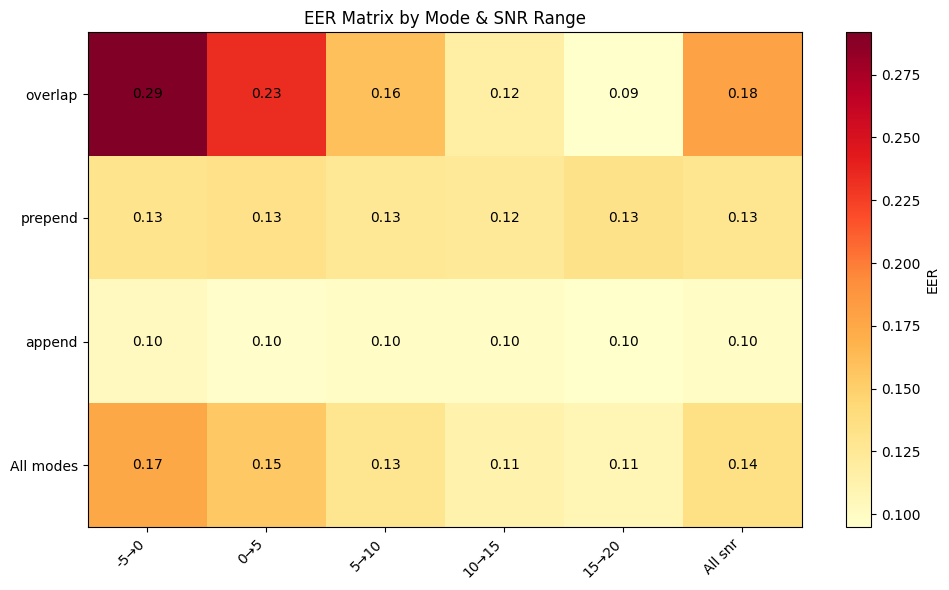

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# plot heatmap từ eer_matrix
fig, ax = plt.subplots(figsize=(10, 6))

# dữ liệu thành numpy array
data = eer_matrix.values.astype(float)

# heatmap
im = ax.imshow(data, cmap="YlOrRd", aspect="auto")

# ticks
ax.set_xticks(np.arange(len(eer_matrix.columns)))
ax.set_yticks(np.arange(len(eer_matrix.index)))
ax.set_xticklabels(eer_matrix.columns, rotation=45, ha="right")
ax.set_yticklabels(eer_matrix.index)

# annotation trong từng ô
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        val = data[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black")

# colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("EER")

plt.title("EER Matrix by Mode & SNR Range")
plt.tight_layout()
plt.show()


In [ ]:
merge_ana.to_csv('res_analysis.csv', index = False)
merge_ana.to_json("res_analysis.json", orient='records', force_ascii=False)

# Type-SNR Analysis

In [ ]:
merge_ana['type'] = merge_ana['id'].str.split('_').str[0:2].str.join('_')

In [ ]:
merge_ana['type'].unique()

array(['single_active', 'single_mix', 'chain_active', 'chain_mix',
       'non_active'], dtype=object)

In [ ]:
import pandas as pd

# định nghĩa bins và labels
bins = [-5, 0, 5, 10, 15, 20]
labels = ["-5→0", "0→5", "5→10", "10→15", "15→20"]

# thêm cột snr_range
merge_ana['snr_range'] = pd.cut(
    merge_ana['snr_db'],
    bins=bins, labels=labels,
    right=True, include_lowest=True
)

modes = merge_ana['type'].unique()
snr_ranges = merge_ana['snr_range'].cat.categories

eer_matrix = pd.DataFrame(index=modes, columns=snr_ranges)

# tính EER cho từng (mode, snr_range)
for mode in modes:
    for snr_range in snr_ranges:
        df_sub = merge_ana[(merge_ana['type'] == mode) & (merge_ana['snr_range'] == snr_range)]
        if not df_sub.empty:
            eer_matrix.loc[mode, snr_range] = compute_eer(df_sub, labels_col="labels_x")
        else:
            eer_matrix.loc[mode, snr_range] = None

# convert sang float để dễ tính toán
eer_matrix = eer_matrix.astype(float)

# thêm hàng tổng kết (mean theo snr_range)
eer_matrix.loc['All modes'] = eer_matrix.mean(axis=0)

# thêm cột tổng kết (mean theo mode)
eer_matrix['All snr'] = eer_matrix.mean(axis=1)

print(eer_matrix)


                   -5→0       0→5      5→10     10→15     15→20   All snr
single_active  0.322033  0.278375  0.276737  0.251128  0.250419  0.275738
single_mix     0.221699  0.214341  0.200232  0.187334  0.181202  0.200962
chain_active   0.238294  0.206564  0.186274  0.168335  0.156109  0.191115
chain_mix      0.175597  0.158269  0.123022  0.115583  0.109430  0.136380
non_active     0.013615  0.011730  0.009106  0.007719  0.007295  0.009893
All modes      0.194248  0.173856  0.159074  0.146020  0.140891  0.162818


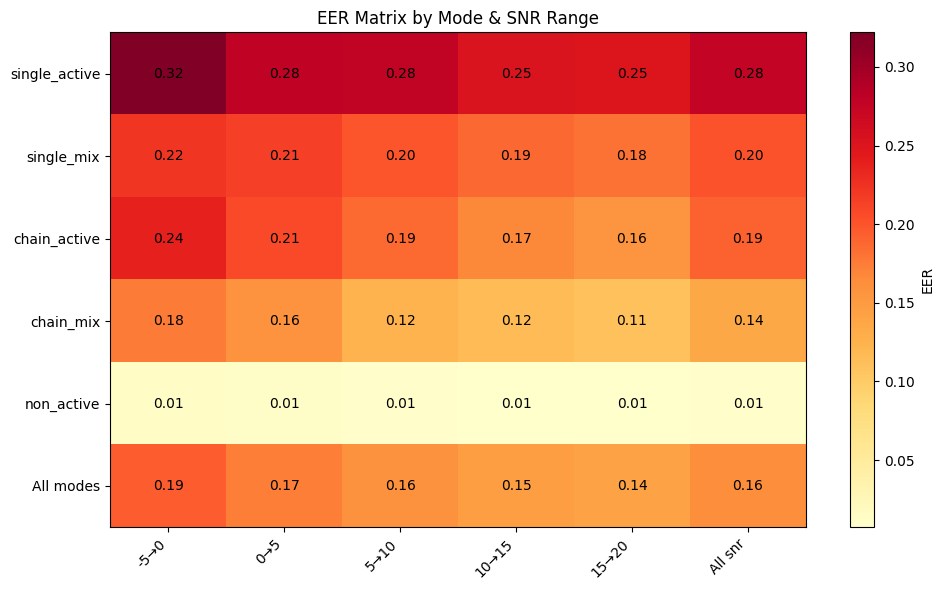

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# plot heatmap từ eer_matrix
fig, ax = plt.subplots(figsize=(10, 6))

# dữ liệu thành numpy array
data = eer_matrix.values.astype(float)

# heatmap
im = ax.imshow(data, cmap="YlOrRd", aspect="auto")

# ticks
ax.set_xticks(np.arange(len(eer_matrix.columns)))
ax.set_yticks(np.arange(len(eer_matrix.index)))
ax.set_xticklabels(eer_matrix.columns, rotation=45, ha="right")
ax.set_yticklabels(eer_matrix.index)

# annotation trong từng ô
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        val = data[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black")

# colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("EER")

plt.title("EER Matrix by Mode & SNR Range")
plt.tight_layout()
plt.show()


# MODE-TYPE ANALYSIS

In [ ]:
import pandas as pd

# lấy unique values cho mode và type
modes = merge_ana['mode'].unique()
types = merge_ana['type'].unique()

# tạo matrix với index = modes, columns = types
eer_matrix = pd.DataFrame(index=modes, columns=types)

# tính EER cho từng (mode, type)
for mode in modes:
    for t in types:
        df_sub = merge_ana[(merge_ana['mode'] == mode) & (merge_ana['type'] == t)]
        if not df_sub.empty:
            eer_matrix.loc[mode, t] = compute_eer(df_sub, labels_col="labels_x")
        else:
            eer_matrix.loc[mode, t] = None

# convert sang float để dễ tính toán
eer_matrix = eer_matrix.astype(float)

# thêm hàng tổng kết (mean theo type)
eer_matrix.loc['All modes'] = eer_matrix.mean(axis=0)

# thêm cột tổng kết (mean theo mode)
eer_matrix['All types'] = eer_matrix.mean(axis=1)

print(eer_matrix)


           single_active  single_mix  chain_active  chain_mix  non_active  \
overlap         0.114899    0.283673      0.102314   0.232294    0.014238   
prepend         0.194352    0.191760      0.114503   0.140515    0.013112   
append          0.315732    0.152653      0.225795   0.072112    0.004499   
All modes       0.208328    0.209362      0.147537   0.148307    0.010617   

           All types  
overlap     0.149484  
prepend     0.130848  
append      0.154158  
All modes   0.144830  


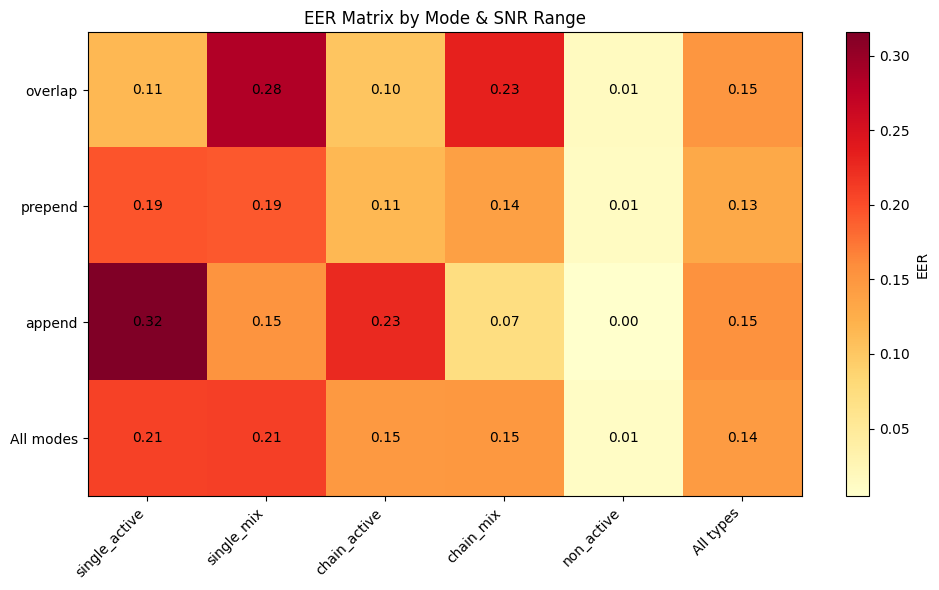

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# plot heatmap từ eer_matrix
fig, ax = plt.subplots(figsize=(10, 6))

# dữ liệu thành numpy array
data = eer_matrix.values.astype(float)

# heatmap
im = ax.imshow(data, cmap="YlOrRd", aspect="auto")

# ticks
ax.set_xticks(np.arange(len(eer_matrix.columns)))
ax.set_yticks(np.arange(len(eer_matrix.index)))
ax.set_xticklabels(eer_matrix.columns, rotation=45, ha="right")
ax.set_yticklabels(eer_matrix.index)

# annotation trong từng ô
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        val = data[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black")

# colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("EER")

plt.title("EER Matrix by Mode & SNR Range")
plt.tight_layout()
plt.show()


In [ ]:
id_samples = merge_ana[merge_ana['id'].str.startswith('chain_mix')].sample(40, random_state = 42)

In [ ]:
from IPython.display import Audio, display

root_folder = root_path
for idx, row in id_samples.iterrows():
    id_sample = row['id']
    for folder in os.listdir(root_folder):
        check = False
        if folder in id_sample:
            for file in os.listdir(os.path.join(root_folder,folder)):
                if file == f'{id_sample}.wav':
                    print(row['preds'])
                    print(row['labels_x'])
                    print(row['f1'])
                    print(row['snr_db'])
                    # Tạo đối tượng audio
                    sound = Audio(os.path.join(root_folder, folder, file))

                    # Hiển thị đối tượng audio (có player)
                    display(sound)
                    check = True

                    break
        if check == True:
            break

# WER

In [ ]:
!gdown 10uHbeqAO5uqOQV6eOXnTuS150MEUTDdk

Downloading...
From (original): https://drive.google.com/uc?id=10uHbeqAO5uqOQV6eOXnTuS150MEUTDdk
From (redirected): https://drive.google.com/uc?id=10uHbeqAO5uqOQV6eOXnTuS150MEUTDdk&confirm=t&uuid=b1cf9e89-d239-4d74-8e88-b361aee8a030
To: /kaggle/working/synthesis.zip
100%|████████████████████████████████████████| 955M/955M [00:11<00:00, 82.9MB/s]


In [ ]:
!unzip -q synthesis.zip

In [ ]:
for file in os.listdir('synthesis'):
    path = f"synthesis/{file}"
    !unzip -q {path}

In [ ]:
merge_ana.iloc[1]

outputs       [0.047425874, 0.047425874, 0.047425874, 0.0474...
preds         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
labels_x      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
pred_time                       [{'start': 1.55, 'end': 3.125}]
text                                                       None
id                                single_active_bd116cf7_aug0-1
precision                                              0.858974
recall                                                      1.0
f1                                                     0.924138
clean_path    /content/concat_speech/sample/single_active_bd...
noise_path    /content/musan/speech/librivox/speech-librivox...
mode                                                    prepend
snr_db                                                 0.609248
labels_y      [{'label': 'active', 'start': 1.78544425099277...
snr_range                                                   0→5
type                                    